# Openness and minerals

The openness is analysed according the presence of a mineral in the fracture. <br> We observe the relationship between the openness and the different stress proxies ($\sigma_n$, $\tau/\tau_c$, $P_c$), by dividing the dataset based on minerals presence. <br> Note that one fracture contains often several minerals, so it can by found in several groups.

### Python packages and functions

In [43]:
import sys, os, math, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path=r'python_functions'
sys.path.append(path)

import utils_fop as uF #functions to calculate openness

In [44]:
#ignore python warnings in the notebook
import warnings
warnings.filterwarnings('ignore')

### Retrieve Forsmark fracture dataset, with stresses calculated in previous notebook

In [45]:
input_folder = r'input_data'
filename = 'p_frac_core_select_with_stresses'
all_data = pd.read_csv(os.path.join(input_folder,filename+str('.txt')), sep = '\t')

## 1) Mineral frequency and openness

In [46]:
min_list = ['Oxidized Walls','Adularia','Epidote','Quartz','Prehnite','Laumontite','Calcite','Hematite','Chlorite','Pyrite','Asphalt','Clay Minerals','NO DETECTABLE MINERAL', 'No data']

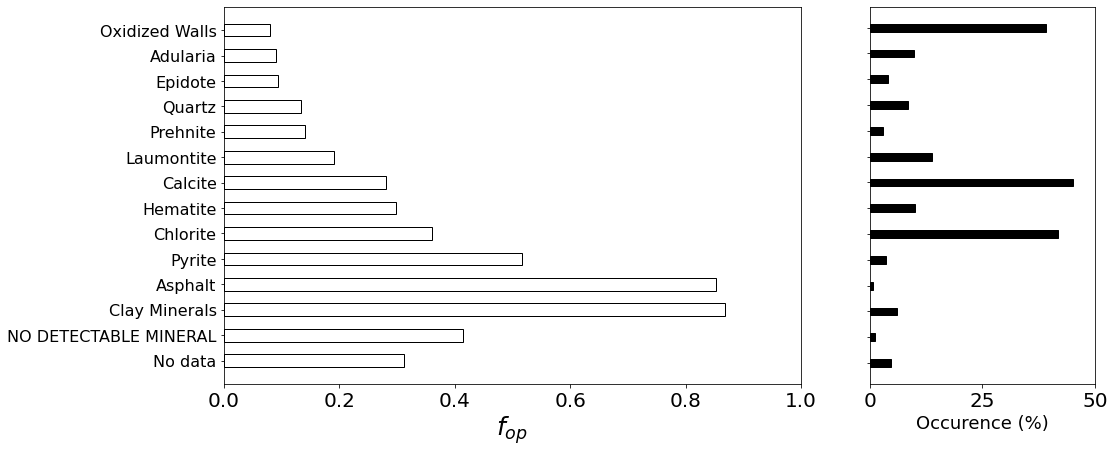

In [47]:
# empty storing lists
fop = [] #mineral openness
f_min = [] #mineral occurence

# loop over minerals
for mineral in min_list:
    # select fractures having this mineral    
    if mineral == 'No data': #no information
        all_data_min = all_data.loc[(all_data['MIN1'].isnull()) & (all_data['MIN2'].isnull()) & (all_data['MIN3'].isnull()) & (all_data['MIN4'].isnull())]
    else:
        all_data_min = all_data.loc[(all_data['MIN1'] == mineral) | (all_data['MIN2'] == mineral) | (all_data['MIN3'] == mineral) | (all_data['MIN4'] == mineral)]
    
    #angle correction (Terzaghi)
    uncertainty = 5  
    max_f = 1/math.sin(uncertainty*math.pi/180)
    factor = 1/(np.sin(all_data_min['ALPHA(degrees)']*math.pi/180))
    factor[factor > max_f] = max_f
    mean = factor.mean()
    factor = factor.fillna(mean)
    all_data_min.loc[:,('factor_min')]=factor

    # select open fractures 
    open_data_min = all_data_min.loc[all_data_min['FRACT_INTERPRET'].isin(['Open','Partly open'])]

    # store occurence and openness    
    f_min.append((all_data_min.shape[0]/all_data.shape[0])*100)
    fop.append(open_data_min['factor_min'].sum()/all_data_min['factor_min'].sum())


#------plots
fig = plt.figure()
ax = plt.subplot2grid((1, 16), (0, 1), colspan = 10)
ax.set_xlabel('$f_{op}$', fontsize = 25)
ax.tick_params(axis="x", labelsize=20)
y_pos = np.arange(len(min_list))
ax.set_yticks(y_pos)
ax.set_yticklabels(min_list, rotation = 0, fontsize = 16, ha = 'right')

ax2 = plt.subplot2grid((1, 16), (0, 12), colspan = 4)
ax2.set_xlabel('Occurence (%)', fontsize = 18)
ax2.tick_params(axis="x", labelsize=20)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([])
ax2.set_xticks([0,25,50])
ax2.set_xticklabels(['0','25','50'])

ax.barh(y_pos, fop, color = 'white', edgecolor = 'black', height=0.5)
ax2.barh(y_pos, f_min, color = 'black', edgecolor = 'black', height=0.3)

# format graph
ax.set_xlim(0,1)
ax2.set_xlim(0,50)
ax.invert_yaxis()
ax2.invert_yaxis()

fig.set_size_inches(1200./fig.dpi,500./fig.dpi)
plt.show()
# save figure
file_path = os.path.join('output_figures', 'minerals')
fig.savefig(file_path)
fig.clf()

## 1b) selection of minerals and failure envelopes
from Glamheden, R., Fredriksson, A., Roeshoff, K., Karlsson, J., Hakami, H., & Christiansson, R. (2007). Rock mechanics Forsmark. Site descriptive modelling Forsmark stage 2.2. SKB reports, R-07-15
|Parameter|Minimum|Mean|Median|Maximum|Std. dev.|
|:----|:---:|:---:|:---:|:---:|:---:|
|Peak friction angle of sealed fractures [°]|48.3|52.6|51.6|57.9|4.9|
|Peak cohesion of sealed fractures [MPa]|2.21|4.06|2.46|7.50|2.99|

In [48]:
# selection of minerals (sublists can be groups of minerals)
mineral_list = [['Chlorite'],['Hematite'], ['Calcite'],['Laumontite'], ['Adularia'],['Quartz'],['Oxidized Walls']] #most present minerals
# mineral_list = [['Chlorite', 'Hematite', 'Calcite'],['Laumontite','Adularia','Prehnite','Quartz','Oxidized Walls']]
# mineral_list = [['Chlorite'],['Hematite'], ['Calcite'],['Laumontite'], ['Adularia'],['Quartz'],['Oxidized Walls']]

# failure envelope parameters (sealed fracture)
mu={'mean':52.6,'min':48.3,'median':51.6,'max':57.9}
cohesion={'mean':4.06,'min':2.21,'median':2.46,'max':7.50}
failure='mean'


# failure envelope parameter
_mu_s = np.tan(mu[failure]/180*np.pi)
_c_s = cohesion[failure]

#selection function
def select_mineral(all_data,mineral):
    name=''
    for i,m in enumerate(mineral):
        r=(all_data['MIN1'] == m)|(all_data['MIN2'] == m)|(all_data['MIN3'] == m)|(all_data['MIN4'] == m)
        if i==0:
            res=r
            name=m
        else:
            res|=r
            name+=(','+m)
    return all_data.loc[res],name

## 2) Openness as a function of normal stress, by minerals

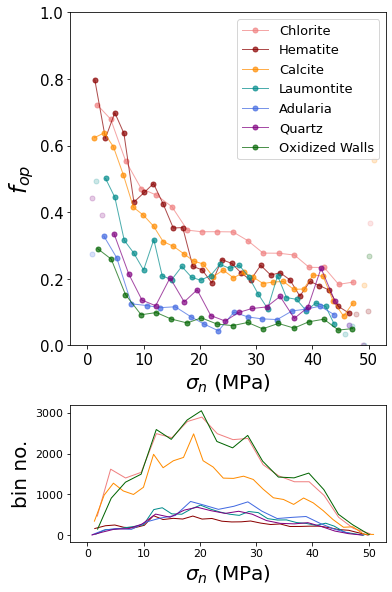

In [49]:
var = 'norm_stress'

# binning parameters
bin_number=30
min_number=100

color = ['lightcoral','darkred','darkorange','darkcyan','royalblue','purple', 'darkgreen','crimson']

fig = plt.figure()
ax = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

for i,_mineral in enumerate(mineral_list):

    dataframe_m,_name = select_mineral(all_data,_mineral) 
    analysis = uF.fop(dataframe_m,var,bin_number=bin_number)
    
    data_valid= analysis.loc[analysis['N']>=min_number]
    data_nvalid=analysis.loc[analysis['N']< min_number]
    ax.plot(data_valid[var] , data_valid['fop32'], linestyle = '-', marker='o', markersize = 5, alpha=0.7, color = color[i], linewidth = 1, label = _name)
    ax.plot(data_nvalid[var], data_nvalid['fop32'], linestyle = '', marker='o', markersize = 5, alpha=0.2, color = color[i])
    ax2.plot(analysis[var], analysis['N'], linestyle = '-', color = color[i], linewidth = 1, label = _name)

# format graph
ax.set_xlabel('$\sigma_n$ (MPa)', fontsize = 20)
ax.set_ylabel('$f_{op}$', fontsize = 23)
ax2.set_xlabel('$\sigma_n$ (MPa)', fontsize = 20)
ax2.set_ylabel('bin no.', fontsize = 20)
ax.legend(fontsize = 13)
ax.set_xlim(-3,53)
ax2.set_xlim(-3,53)
ax.set_ylim(0,1)
ax.tick_params(labelsize = 15)
ax2.tick_params(labelsize = 11)


fig.set_tight_layout(True)
fig.set_size_inches(400./fig.dpi,600./fig.dpi)
plt.show()

#save figure
file_path = os.path.join('output_figures', var+'_by_minerals')
fig.savefig(file_path)
fig.clf()

## 3a) Openness as a function of shear, by minerals

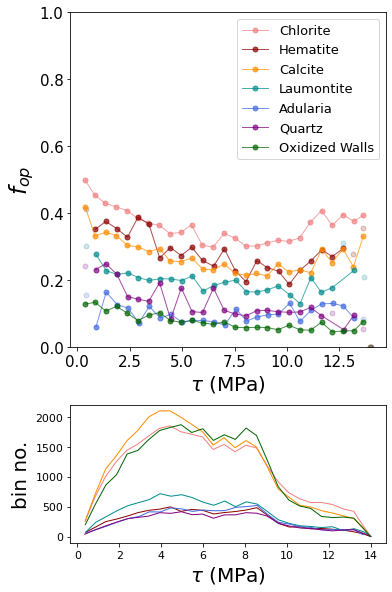

In [50]:
var = 'tan_stress'

# binning parameters
bin_number=30
min_number=100
bin_max = 15

fig = plt.figure()
ax = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

for i,_mineral in enumerate(mineral_list):
    dataframe_m,_name = select_mineral(all_data,_mineral)
    analysis = uF.fop(dataframe_m,var,bin_number=bin_number, max=bin_max)
    
    data_valid= analysis.loc[analysis['N']>=min_number]
    data_nvalid=analysis.loc[analysis['N']< min_number]
    ax.plot(data_valid[var] , data_valid['fop32'], linestyle = '-', marker='o', markersize = 5, alpha=0.7, color = color[i], linewidth = 1, label = _name)
    ax.plot(data_nvalid[var], data_nvalid['fop32'], linestyle = '', marker='o', markersize = 5, alpha=0.2, color = color[i])
    ax2.plot(analysis[var], analysis['N'], linestyle = '-', color = color[i], linewidth = 1, label = _name)

# format graph
ax.set_xlabel('$\u03C4$ (MPa)', fontsize = 20)
ax.set_ylabel('$f_{op}$', fontsize = 23)
ax2.set_xlabel('$\u03C4$ (MPa)', fontsize = 20)
ax2.set_ylabel('bin no.', fontsize = 20)
ax.legend(fontsize = 13)
ax.set_ylim(0,1)
ax.tick_params(labelsize = 15)
ax2.tick_params(labelsize = 11)


fig.set_tight_layout(True)
fig.set_size_inches(400./fig.dpi,600./fig.dpi)
plt.show()

#save figure
file_path = os.path.join('output_figures', var+'_by_minerals')
fig.savefig(file_path)
fig.clf()


## 3b) Openness as a function of shear failure proxy, by minerals

In [51]:
# critical shear stress
tau_c = _mu_s*all_data['norm_stress']+_c_s

# shear failure proxy 
all_data['shear_proxy'] = all_data['tan_stress']/tau_c

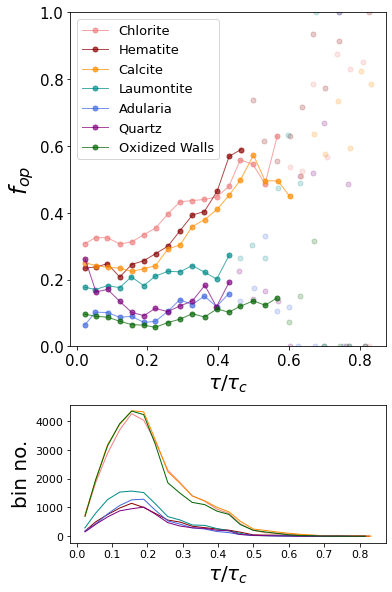

In [52]:
var = 'shear_proxy'

# binning parameters
bin_number=30
min_number=100
bin_min = 0
bin_max = 1

fig = plt.figure()
ax = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

for i,_mineral in enumerate(mineral_list):
    dataframe_m,_name = select_mineral(all_data,_mineral)
    analysis = uF.fop(dataframe_m,var,bin_number=bin_number, min=bin_min, max = bin_max)
    
    data_valid= analysis.loc[analysis['N']>=min_number]
    data_nvalid=analysis.loc[analysis['N']< min_number]
    ax.plot(data_valid[var] , data_valid['fop32'], linestyle = '-', marker='o', markersize = 5, alpha=0.7, color = color[i], linewidth = 1, label = _name)
    ax.plot(data_nvalid[var], data_nvalid['fop32'], linestyle = '', marker='o', markersize = 5, alpha=0.2, color = color[i])
    ax2.plot(analysis[var], analysis['N'], linestyle = '-', color = color[i], linewidth = 1, label = _name)

# format graph
ax.set_xlabel('$\u03C4/\u03C4_c$', fontsize = 20)
ax.set_ylabel('$f_{op}$', fontsize = 23)
ax2.set_xlabel('$\u03C4/\u03C4_c$', fontsize = 20)
ax2.set_ylabel('bin no.', fontsize = 20)
ax.legend(fontsize = 13)
ax.set_ylim(0,1)
ax.tick_params(labelsize = 15)
ax2.tick_params(labelsize = 11)

fig.set_tight_layout(True)
fig.set_size_inches(400./fig.dpi,600./fig.dpi)
plt.show()

#save figure
file_path = os.path.join('output_figures', var+'_by_minerals')
fig.savefig(file_path)
fig.clf()

## 4) Openness as a function of critical pressure, by minerals

In [53]:
# Critical fluid pressure (MPa)
all_data['Pc'] = all_data['norm_stress'] - (all_data['tan_stress']-_c_s)/_mu_s

# Hydrological and lithological fluid pressure (MPa)
_gw = 9.81*1000 #(rho*g)
pf_hydro = (_gw*-all_data['ELEVATION_ADJUSTEDSECUP'])*10**-6
pf_litho = (-all_data['V_stress']-all_data['H_stress']-all_data['h_stress'])/3

# Normalize critical fluid pressure
all_data['Pc_norm'] = (all_data['Pc'] - pf_hydro)/(pf_litho - pf_hydro)

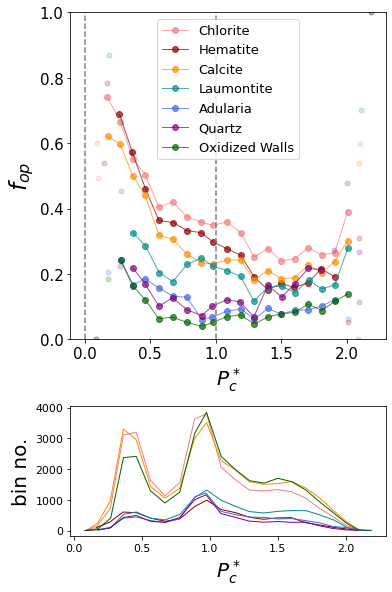

In [54]:
var = 'Pc_norm'

# binning parameters
bin_number=30
min_number=100
bin_min = 0
bin_max = 3

fig = plt.figure()
ax = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan = 1)

for i,_mineral in enumerate(mineral_list):
    dataframe_m,_name = select_mineral(all_data,_mineral)
    analysis = uF.fop(dataframe_m,var,bin_number=bin_number,  min=bin_min, max = bin_max)
    
    data_valid= analysis.loc[analysis['N']>=min_number]
    data_nvalid=analysis.loc[analysis['N']< min_number]
    ax.plot(data_valid[var] , data_valid['fop32'], linestyle = '-', marker='o', alpha=0.7, color = color[i], linewidth = 1, label = _name)
    ax.plot(data_nvalid[var], data_nvalid['fop32'], linestyle = '', marker='o', markersize = 5, alpha=0.2, color = color[i])
    ax2.plot(analysis[var], analysis['N'], linestyle = '-', color = color[i], linewidth = 1, label = _name)

# vertical lines (hydrostatic (0) and lithostatic (1) pressures)
ax.vlines(0, 0, 1, colors='gray', linestyles='--')
ax.vlines(1, 0, 1, colors='gray', linestyles='--')

# format graph
ax.set_xlabel('$P_c^*$', fontsize = 20)
ax.set_ylabel('$f_{op}$', fontsize = 23)
ax2.set_xlabel('$P_c^*$', fontsize = 20)
ax2.set_ylabel('bin no.', fontsize = 20)
ax.legend(fontsize = 13)
ax.set_ylim(0,1)
ax.tick_params(labelsize = 15)
ax2.tick_params(labelsize = 11)


fig.set_tight_layout(True)
fig.set_size_inches(400./fig.dpi,600./fig.dpi)
plt.show()

#save figure
file_path = os.path.join('output_figures', var+'_by_minerals')
fig.savefig(file_path)
fig.clf()